# 基于Transformer的说话人识别算法

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torchaudio
from torchaudio.transforms import MFCC
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## 基础知识

### 梅尔频率倒谱系数

MFCC（Mel Frequency Cepstral Coefficients，梅尔频率倒谱系数）是语音信号处理中常用的一种特征提取方法，广泛应用于语音识别、音频处理等领域。MFCC的目的是将音频信号转换为一个更适合机器学习模型处理的特征表示。

MFCC的基本步骤：
- 分帧（Framing）：将音频信号分割成多个小的时间片段，每个片段通常为20-40毫秒。这是因为语音信号在短时间内可以近似为平稳信号。

- 窗口加权（Windowing）：对每一帧信号应用窗函数（通常是汉明窗或汉宁窗），以减小帧之间的边界效应。

- 快速傅里叶变换（FFT）：对每一帧信号进行FFT变换，得到信号的频谱表示。

- Mel频率滤波器组：将频谱经过Mel频率尺度的滤波器组进行滤波。Mel尺度是一种对人耳听觉特性的模拟，它在低频段具有更高的分辨率，而在高频段分辨率较低。

- 对数变换：对滤波器输出的能量进行对数变换，这一操作是为了模拟人耳对声音强度的感知。

- 离散余弦变换（DCT）：对经过Mel频率滤波后的能量谱进行离散余弦变换，最终得到MFCC系数。

### MFCC

构造函数：MFCC:
- sample_rate（int）：音频的采样率。通常音频文件的采样率为16000、22050、44100等，这会影响特征提取的精度和速度。

- n_mfcc（int）：要提取的MFCC系数的数量。通常选择13个MFCC系数，这些系数能够有效捕捉音频信号的特征。n_mfcc的默认值是13。

- melkwargs（dict，可选）：一个字典，包含Mel滤波器组的参数配置。常见的参数包括：

    - n_fft: 用于计算FFT的窗口大小（以样本为单位），默认值通常是400。
    - hop_length: 每一帧的步长（以样本为单位），默认值通常是160。
    - n_mels: Mel滤波器的数量，决定了Mel频率尺度的分辨率。默认通常为23。
    - center: 是否将FFT窗口居中，默认为True。

forward方法是MFCC类的核心功能，它执行音频信号的MFCC特征提取过程。调用transform(waveform)时，实际上是调用forward方法。
- waveform（Tensor）：一个形状为 (channel, time) 的音频波形张量。通常情况下，channel表示音频的声道数（单声道是1，立体声是2），time表示音频的样本数。

- 返回值：一个形状为 (n_mfcc, time) 的张量，包含了提取的MFCC系数。n_mfcc是MFCC系数的数量，time是帧数（即音频信号的时长被分割成的小帧数量，**每帧代表每个时间步**）。

### 举例说明

In [55]:
import torch
import torchaudio
from torchaudio.transforms import MFCC

# 读取立体声音频（2通道）
waveform, sample_rate = torchaudio.load('../data\\cyy1.wav')

# 设置MFCC转换器
mfcc_transform = MFCC(
    sample_rate=sample_rate,
    n_mfcc=13,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23, 'center': False}
)

# 处理左右声道
mfcc_left = mfcc_transform(waveform[0])  # 左声道
mfcc_right = mfcc_transform(waveform[1])  # 右声道

# 你可以将它们分别输入模型
print(mfcc_left.shape, mfcc_right.shape)

torch.Size([13, 9981]) torch.Size([13, 9981])


In [57]:
waveform[0].size()

torch.Size([1597200])

## 数据准备

In [ ]:
1、先读取数据
2、将读取的数据分段，每段长度一样，舍弃最后一段
3、将每段MFCC


In [106]:
# 将每个人的音频进行分段
def select_data(wave_data):
    length = int(0.2 * 48000)  # 0.2s为一段,每段9600个数据
    seg = int(np.ceil(len(wave_data) / (length)))  # 分成的段数,向上取整
    seg1 = seg - 1  # 不包含最后一段，因为有可能包含0
    zeros = torch.zeros(length * seg - len(wave_data))
    wave_data_new = torch.cat([wave_data, zeros
                                    ]).reshape(seg,
                                               length)  # 将原数组变成seg*length的数组
    wave_data_new = wave_data_new[:len(wave_data_new) - 1]
    return wave_data_new

# 加载所有音频
def loader(data_path):
    """data_path: 音频文件夹"""
    # 遍历音频文件夹
    for index, file in enumerate(os.listdir(data_path)):
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            # 读取立体声音频（2通道）
            waveform, sample_rate = torchaudio.load(file_path)
            waveform_left, waveform_right = select_data(
                waveform[0, :]), select_data(waveform[1, :])
            waveform_con = torch.cat([waveform_left, waveform_right])
            label = torch.tensor([index] * waveform_con.shape[0]).reshape((-1, 1))

            # 合并每个人的音频
            if index == 0:
                waveforms = waveform_con
                labels = label
            else:
                waveforms = torch.cat([waveforms, waveform_con])
                labels = torch.cat([labels, label])

    return waveforms, labels

In [116]:
x, y = loader("../data")
print("x shape: {0} y shape: {1}".format(x.shape, y.shape))

x shape: torch.Size([4066, 9600]) y shape: torch.Size([4066, 1])


In [110]:
# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("x_train shape: {0} y_train shape: {1}".format(
    x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(
    x_test.shape, y_test.shape))

x_train shape: torch.Size([3252, 9600]) y_train shape: torch.Size([3252, 1])
x_valid shape: torch.Size([814, 9600]) y_valid shape: torch.Size([814, 1])


In [111]:
# 生成数据集
def generator(data_list, batch_size):
    # 获取数据
    feature = data_list[0]  # 特征
    target = data_list[1]  # 目标
    
    # MFCC初始化
    mfcc_transform = MFCC(
        sample_rate=16000,  # 假设采样率为16000
        n_mfcc=13,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23, 'center': False}
    )
    
    # 音频类
    class AudioDataset(torch.utils.data.Dataset):
        def __init__(self, waveforms, labels, transform=None):
            self.waveforms = waveforms
            self.labels = labels
            self.transform = transform
    
        def __len__(self):
            return len(self.waveforms)
    
        def __getitem__(self, idx):
            # 获取音频和标签
            waveforms = self.waveforms[idx]
            label = self.labels[idx]
            
            # MFCC
            mfcc_features = mfcc_transform(torch.tensor(waveforms, dtype = torch.float32))
    
            return mfcc_features.permute(1, 0), torch.tensor(label, dtype = torch.long)

    # 生成数据集
    dataset = AudioDataset(feature, target, transform=mfcc_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [114]:
# 构造参数字典
params2 = {
    "batch_size": 32,
}
train_loader = generator([x_train, y_train], **params2)
valid_loader = generator([x_test, y_train], **params2)
print("train_loader_len: {}".format(len(train_loader)))
print("test_loader_len: {}".format(len(valid_loader)))

train_loader_len: 102
test_loader_len: 26


In [115]:
32*102

3264

In [39]:
train_files, test_files, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=42)

In [51]:
train_files[0].shape

(9600,)

In [61]:
mfcc_transform(torch.tensor(train_files[0], dtype = torch.float32)).shape

torch.Size([13, 58])

In [78]:
# 
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, waveforms, labels, transform=None):
        self.waveforms = waveforms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        # 获取音频和标签
        waveforms = self.waveforms[idx]
        label = self.labels[idx]
        
        # MFCC
        mfcc_features = mfcc_transform(torch.tensor(waveforms, dtype = torch.float32))

        return mfcc_features.permute(1, 0), torch.tensor(label, dtype = torch.long)

In [79]:
mfcc_transform = MFCC(
    sample_rate=16000,  # 假设采样率为16000
    n_mfcc=13,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23, 'center': False}
)

In [80]:
dataset = AudioDataset(train_files, train_labels, transform=mfcc_transform)

In [81]:
for i, j in dataset:
    print(i.shape)
    print(j)
    break

torch.Size([58, 13])
tensor([10])


In [86]:
dataloader = generator([train_files, train_labels], 32)

# 获取一个batch并检查结果
for batch in dataloader:
    mfcc_features, labels = batch
    print(f"MFCC Features Shape: {mfcc_features.shape}")
    print(f"Labels: {labels}")
    break

MFCC Features Shape: torch.Size([32, 58, 13])
Labels: tensor([[ 8],
        [ 5],
        [ 4],
        [ 3],
        [ 2],
        [ 2],
        [ 2],
        [ 5],
        [ 5],
        [ 6],
        [ 5],
        [ 2],
        [ 9],
        [ 4],
        [ 5],
        [ 0],
        [ 8],
        [ 3],
        [ 5],
        [ 5],
        [ 7],
        [11],
        [ 8],
        [ 4],
        [ 8],
        [ 5],
        [ 7],
        [ 8],
        [ 4],
        [ 2],
        [ 6],
        [ 0]])


In [34]:
x, y = loader("../data")

In [35]:
x.shape

(4066, 9600)

In [37]:
y

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [11],
       [11],
       [11]])

In [23]:
# 将每个人的音频进行分段
def select_data(wave_data):
    length = int(2 * 48000)  # 2s为一段,每段9600个数据
    seg = int(np.ceil(len(wave_data) / (length)))  # 分成的段数,向上取整
    seg1 = seg - 1  # 不包含最后一段，因为有可能包含0
    zeros = np.zeros(length * seg - len(wave_data))
    wave_data_new = np.concatenate([wave_data, zeros
                                     ]).reshape(seg,
                                                length)  # 将原数组变成seg*length的数组
    wave_data_new = wave_data_new[:len(wave_data_new) - 1]
    return wave_data_new

In [24]:
wave_data = select_data(waveform[1, :].numpy())
wave_data.shape

(16, 96000)

In [18]:
166*9600

1593600

In [ ]:
waveform_left

In [29]:
np.concatenate([select_data(waveform[0, :].numpy()), select_data(waveform[1, :].numpy())]).shape

(32, 96000)

In [7]:
mfcc_transform = MFCC(
    sample_rate=16000,  # 假设采样率为16000
    n_mfcc=13,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23, 'center': False}
)

In [8]:
mfcc_left = mfcc_transform(waveform)
mfcc_left.shape

torch.Size([2, 13, 9981])

In [9]:
9981*160

1596960

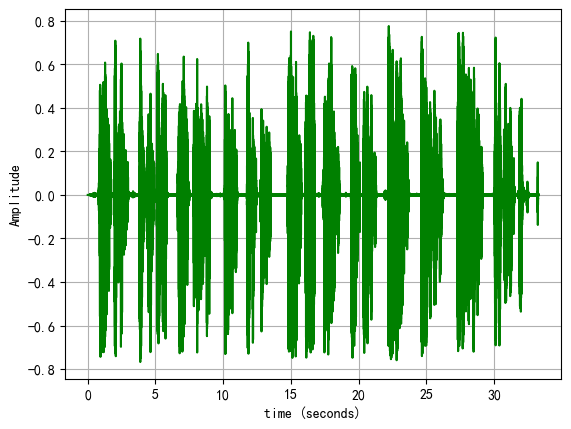

torch.Size([1597200])

In [4]:
def Time(wave_data):
    # 通过采样点数和取样频率计算出每个取样的时间
    time = np.arange(0, len(wave_data)) * (1.0 / 48000)
    plt.plot(time, wave_data, c="g")  #取单声道绘制时域图
    plt.xlabel("time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()
    return (wave_data.shape)
#绘制时域图
Time(waveform[0, :])

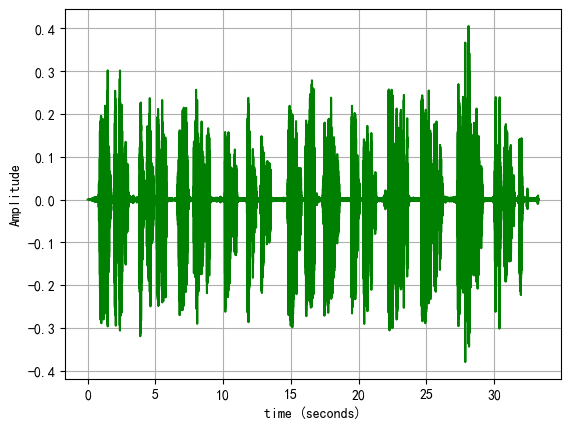

torch.Size([1597200])

In [5]:
Time(waveform[1, :])

In [ ]:
max_length每段长度

In [ ]:
def loader(data_path, max_length=16000):
    """data_path: 音频文件夹"""
    # 遍历音频文件夹
    for index, file in enumerate(os.listdir(data_path)):
        if file.endswith('.wav'):
            speaker_name = file.split('_')[0]
            file_path = os.path.join(data_path, file)
            # 读取立体声音频（2通道）
            waveform, sample_rate = torchaudio.load(file_path)


    # # 输出为数据框
    # data = pd.DataFrame(data=merge_mfcc.numpy(), columns=[f'mfcc_{i}' for i in range(merge_mfcc.shape[1]-1)] + ['label'])
    
    # return data

In [73]:
import torch
import torchaudio
from torchaudio.transforms import MFCC
import os

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels, transform=None, max_length=None):
        self.audio_paths = audio_paths
        self.labels = labels
        self.transform = transform
        self.max_length = max_length  # 最大长度

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # 获取音频路径和标签
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        
        # 读取音频文件
        waveform, sample_rate = torchaudio.load(audio_path)

        # 应用MFCC变换
        mfcc_left = self.transform(waveform[0])  # 左声道
        mfcc_right = self.transform(waveform[1])  # 右声道
        mfcc_features = torch.cat([mfcc_left, mfcc_right], dim=0)  # 拼接特征
        
        # 如果设置了max_length，则裁剪或填充
        if self.max_length:
            # 获取当前音频的帧数
            num_frames = mfcc_features.shape[1]
            
            if num_frames > self.max_length:  # 如果帧数超过max_length，则裁剪
                mfcc_features = mfcc_features[:, :self.max_length]
            elif num_frames < self.max_length:  # 如果帧数不足max_length，则填充
                padding = self.max_length - num_frames
                mfcc_features = torch.nn.functional.pad(mfcc_features, (0, padding))  # 在时间轴上填充

        return mfcc_features, label

# 获取所有wav文件路径
audio_paths = [os.path.join("../data/", file) for file in os.listdir("../data/") if file.endswith('.wav')]
labels = [i for i in range(len(audio_paths))] # 假设的标签

# 设置MFCC转换器
mfcc_transform = MFCC(
    sample_rate=16000,  # 假设采样率为16000
    n_mfcc=13,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23, 'center': False}
)

# 创建数据集，设置最大长度
max_length = 8200  # 设定最大帧数
dataset = AudioDataset(audio_paths, labels, transform=mfcc_transform, max_length=max_length)

# 创建数据加载器
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# 获取一个batch并检查结果
for batch in dataloader:
    mfcc_features, labels = batch
    print(f"MFCC Features Shape: {mfcc_features.shape}")
    print(f"Labels: {labels}")

MFCC Features Shape: torch.Size([12, 26, 8200])
Labels: tensor([ 6,  1,  4, 11,  3,  5,  7, 10,  2,  9,  8,  0])


In [10]:
51*4800

244800

In [85]:
import torch
import torchaudio
from torchaudio.transforms import MFCC
import os

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels, transform=None, max_length=None, num_splits=100):
        self.audio_paths = audio_paths
        self.labels = labels
        self.transform = transform
        self.max_length = max_length  # 最大长度
        self.num_splits = num_splits  # 切分的份数

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # 获取音频路径和标签
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        
        # 读取音频文件
        waveform, sample_rate = torchaudio.load(audio_path)

        # 计算每一段的长度
        total_length = waveform.shape[1]
        split_length = total_length // self.num_splits  # 每一段的长度
        
        # 将音频切分成 num_splits 份
        waveform_splits = [waveform[:, i*split_length:(i+1)*split_length] for i in range(self.num_splits)]
        
        # 如果最后一段不足 `split_length`，则将其补充到剩余部分
        if total_length % self.num_splits != 0:
            remainder = total_length % self.num_splits
            waveform_splits[-1] = torch.cat([waveform_splits[-1], waveform[:, -remainder:]], dim=1)
        
        # 处理每一段的 MFCC 特征
        mfcc_features_list = []
        for wave in waveform_splits:
            # 应用MFCC变换
            mfcc_left = self.transform(wave[0])  # 左声道
            if wave.shape[0] > 1:  # 如果是立体声，有右声道
                mfcc_right = self.transform(wave[1])  # 右声道
                mfcc_features = torch.cat([mfcc_left, mfcc_right], dim=0)  # 拼接特征
            else:  # 如果是单声道
                mfcc_features = mfcc_left
            mfcc_features_list.append(mfcc_features)
        
        # 将所有片段的特征拼接起来
        mfcc_features = torch.cat(mfcc_features_list, dim=1)

        # 如果设置了max_length，则裁剪或填充
        if self.max_length:
            # 获取当前音频的帧数
            num_frames = mfcc_features.shape[1]
            
            if num_frames > self.max_length:  # 如果帧数超过max_length，则裁剪
                mfcc_features = mfcc_features[:, :self.max_length]
            elif num_frames < self.max_length:  # 如果帧数不足max_length，则填充
                padding = self.max_length - num_frames
                mfcc_features = torch.nn.functional.pad(mfcc_features, (0, padding))  # 在时间轴上填充

        return mfcc_features, label

# 获取所有wav文件路径
audio_paths = [os.path.join("../data/", file) for file in os.listdir("../data/") if file.endswith('.wav')]
labels = [i for i in range(len(audio_paths))]  # 假设的标签

# 设置MFCC转换器
mfcc_transform = MFCC(
    sample_rate=16000,  # 假设采样率为16000
    n_mfcc=13,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23, 'center': False}
)

# 创建数据集，设置最大长度和切分份数
max_length = 8200  # 设定最大帧数
num_splits = 100  # 切分为100份
dataset = AudioDataset(audio_paths, labels, transform=mfcc_transform, max_length=max_length, num_splits=num_splits)

# 创建数据加载器
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# 获取一个batch并检查结果
for batch in dataloader:
    mfcc_features, labels = batch
    print(f"MFCC Features Shape: {mfcc_features.shape}")
    print(f"Labels: {labels}")


MFCC Features Shape: torch.Size([12, 26, 8200])
Labels: tensor([ 6,  8,  3, 11, 10,  5,  0,  9,  4,  1,  7,  2])


In [ ]:
[for file in os.listdir(data_path):
        if file.endswith('.wav'):
            speaker_name = file.split('_')[0]
            file_path = os.path.join(data_path, file)]

In [69]:
[os.path.join("../data/", file) for file in os.listdir("../data/") if file.endswith('.wav')]

['../data/cj1.wav',
 '../data/cyy1.wav',
 '../data/djj1.wav',
 '../data/fxf1.wav',
 '../data/lpy1.wav',
 '../data/mf1.wav',
 '../data/op1.wav',
 '../data/sbb1.wav',
 '../data/sx1.wav',
 '../data/xll1.wav',
 '../data/xmm1.wav',
 '../data/ywy1.wav']

In [74]:
torch.randn(100, 16000), torch.randint(0, 10, (100,)).shape

(tensor([[-1.0413,  1.8571,  0.9257,  ...,  1.4041, -0.3414,  0.3613],
         [-0.4616,  1.3171, -0.4432,  ..., -1.1339, -1.3179, -0.2706],
         [-1.9365, -0.8408, -1.0404,  ..., -0.0537, -0.6968, -1.4398],
         ...,
         [ 0.6060, -0.8482,  0.3014,  ...,  1.1366, -0.0249, -1.6494],
         [-0.8780,  0.9590, -0.1987,  ...,  0.5861, -1.0666,  0.4071],
         [ 0.0815,  0.2428, -1.0920,  ..., -1.8452, -0.0228,  1.2840]]),
 torch.Size([100]))

In [76]:
def load_dataset():  
    # 这里应该加载数据集并返回训练集和测试集  
    # 这里只是返回一个模拟的数据集  
    return torch.randn(100, 16000), torch.randint(0, 10, (100,))  # 假设有100个样本，每个样本16000个采样点，标签为0-9 

In [79]:
mfcc = MFCC(sample_rate=16000, n_mfcc=40)  
  
# 加载数据  
waveform, labels = load_dataset()  
# 提取特征（这里仅展示单个样本的处理方式）  
features = mfcc(waveform)  # 实际应用中应对所有样本进行特征提取 

In [80]:
features.shape

torch.Size([100, 40, 81])

In [81]:
waveform, sample_rate = torchaudio.load('../data\\cyy1.wav')

In [83]:
waveform.shape

torch.Size([2, 1597200])

In [ ]:
torch.Size([13, 9981]) torch.Size([13, 9981])

In [84]:
waveform, sample_rate = torchaudio.load('../data\\cj1.wav')
waveform.shape

torch.Size([2, 1587840])

In [9]:
# 左右声道拼接，结果为(时间步，特征)
torch.cat([mfcc_left, mfcc_right], dim=0).T.shape

torch.Size([9981, 26])

In [70]:
def loader(data_path):
    """data_path: 音频文件夹"""
    # 遍历音频文件夹
    for index, file in enumerate(os.listdir(data_path)):
        if file.endswith('.wav'):
            speaker_name = file.split('_')[0]
            file_path = os.path.join(data_path, file)
            # 读取立体声音频（2通道）
            waveform, sample_rate = torchaudio.load(file_path)
            # 设置MFCC转换器
            mfcc_transform = MFCC(
                sample_rate=sample_rate,
                n_mfcc=13,
                melkwargs={'n_fft': 400, 'hop_length': 160,
                           'n_mels': 23, 'center': False})
            # 处理左右声道
            mfcc_left = mfcc_transform(waveform[0])  # 左声道
            mfcc_right = mfcc_transform(waveform[1])  # 右声道
            # 左右声道拼接，结果为(时间步，特征)
            if index == 0:
                # 左右声道拼接，结果为(时间步，特征)
                merge_mfcc = torch.cat([mfcc_left, mfcc_right], dim=0).T
                # 插入标签列
                labels = torch.tensor([index]*merge_mfcc.shape[0]).unsqueeze(1)
                merge_mfcc = torch.cat([merge_mfcc, labels], dim=1)
                print(f"{speaker_name}", merge_mfcc.shape)
            else:
                # 左右声道拼接，结果为(时间步，特征)
                mfcc = torch.cat([mfcc_left, mfcc_right], dim=0).T
                # 插入标签列
                labels = torch.tensor([index]*mfcc.shape[0]).unsqueeze(1)
                mfcc = torch.cat([mfcc, labels], dim=1)
                print(f"{speaker_name}: ", mfcc.shape)
                # 每个人的音频合并
    #             merge_mfcc = torch.cat([merge_mfcc, mfcc], dim=0)
    # # 输出为数据框
    # data = pd.DataFrame(data=merge_mfcc.numpy(), columns=[f'mfcc_{i}' for i in range(merge_mfcc.shape[1]-1)] + ['label'])
    
    # return data

In [71]:
data_path = "../data/"
ts_data = loader(data_path=data_path)
ts_data

cj1.wav torch.Size([9922, 27])
cyy1.wav:  torch.Size([9981, 27])
djj1.wav:  torch.Size([11133, 27])
fxf1.wav:  torch.Size([11184, 27])
lpy1.wav:  torch.Size([11919, 27])
mf1.wav:  torch.Size([9366, 27])
op1.wav:  torch.Size([8572, 27])
sbb1.wav:  torch.Size([11446, 27])
sx1.wav:  torch.Size([11362, 27])
xll1.wav:  torch.Size([10024, 27])
xmm1.wav:  torch.Size([8245, 27])
ywy1.wav:  torch.Size([9142, 27])


In [16]:
def divider(speaker_data, segment_duration=0.2, test_size=0.1, random_state=42):
    """
    将音频文件切分为指定时长的片段，并按比例划分训练集和测试集
    :param speaker_data: 一个字典，键为说话人，值为该说话人的音频文件路径列表
    :param segment_duration: 每个音频片段的时长（单位：秒），可以使用小数
    :param test_size: 测试集占比
    :param random_state: 随机种子，确保每次划分的结果相同
    :return: 切分后的训练集和测试集文件路径及对应标签
    """
    file_paths = []
    labels = []
    label_map = {speaker: idx for idx, speaker in enumerate(speaker_data.keys())}  # 创建标签映射

    # 每个语音文件按时长切分
    for speaker_id, files in speaker_data.items():
        for file in files:
            waveform, sample_rate = torchaudio.load(file)  # 读取音频文件
            duration = waveform.shape[1] / sample_rate  # 计算音频时长

            # 使用 numpy.arange 生成小数步长的切分
            for start_time in np.arange(0, duration, segment_duration):  # 使用小数步长
                end_time = min(start_time + segment_duration, duration)
                segment = waveform[:, int(start_time * sample_rate):int(end_time * sample_rate)]

                # 保存切分后的片段
                file_paths.append(segment)
                labels.append(label_map[speaker_id])  # 使用标签映射

    # 使用train_test_split按比例划分训练集和测试集
    train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=test_size, random_state=random_state)

    return train_files, test_files, train_labels, test_labels, label_map

In [65]:
def divider(speaker_data, segment_duration=0.2, test_size=0.1, random_state=42, mfcc_n_mels=23, mfcc_n_mfcc=13):
    """
    将音频文件切分为指定时长的片段，并按比例划分训练集和测试集，同时提取 MFCC 特征
    :param speaker_data: 一个字典，键为说话人，值为该说话人的音频文件路径列表
    :param segment_duration: 每个音频片段的时长（单位：秒）
    :param test_size: 测试集占比
    :param random_state: 随机种子，确保每次划分的结果相同
    :param mfcc_n_mels: MFCC的梅尔滤波器个数
    :param mfcc_n_mfcc: 提取的MFCC系数个数
    :return: 切分后的训练集和测试集的MFCC特征及对应标签
    """
    file_paths = []
    labels = []
    features = []
    label_map = {speaker: idx for idx, speaker in enumerate(speaker_data.keys())}  # 标签映射

    # MFCC 提取器
    mfcc_transform = MFCC(sample_rate=16000, n_mfcc=40, melkwargs={'hop_length': 160}) 

    # 每个语音文件按时长切分
    for speaker_id, files in speaker_data.items():
        for file in files:
            waveform, sample_rate = torchaudio.load(file)  # 读取音频文件
            duration = waveform.shape[1] / sample_rate  # 计算音频时长

            # 使用 numpy.arange 生成小数步长的切分
            for start_time in np.arange(0, duration, segment_duration):  # 使用小数步长
                end_time = min(start_time + segment_duration, duration)
                segment = waveform[:, int(start_time * sample_rate):int(end_time * sample_rate)]

                # 提取MFCC特征
                print(segment.shape)
                mfcc = mfcc_transform(segment)
                print(mfcc.shape)
                # mfcc = mfcc.mean(dim=-1)  # 对时间维度进行平均，得到固定长度的特征向量
                print(mfcc.shape)

                features.append(mfcc)
                file_paths.append(file)
                labels.append(label_map[speaker_id])  # 标签

    # 转换为Tensor
    features = torch.stack(features)
    print(features.shape)
    labels = np.array(labels)

    # 使用train_test_split按比例划分训练集和测试集
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=test_size, random_state=random_state)

    return train_features, test_features, train_labels, test_labels, label_map


In [66]:
train_files, test_files, train_labels, test_labels, label_map = divider(speaker_data)

# 打印划分后的数据量和标签映射
print(f"训练集数量: {len(train_files)}")
print(f"测试集数量: {len(test_files)}")
print(f"标签映射: {label_map}")

torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600])
torch.Size([2, 40, 61])
torch.Size([2, 40, 61])
torch.Size([2, 9600]

RuntimeError: stack expects each tensor to be equal size, but got [2, 40, 61] at entry 0 and [2, 40, 60] at entry 40

In [64]:
# 封装为generator函数
def generator(train_files, train_labels, test_files, test_labels, batch_size=32):
    """
    生成训练集和测试集的DataLoader
    :param train_files: 训练集文件路径列表
    :param train_labels: 训练集标签列表
    :param test_files: 测试集文件路径列表
    :param test_labels: 测试集标签列表
    :param transform: 音频变换（如MFCC等）
    :param batch_size: 每批次的大小
    :return: 训练集和测试集的DataLoader
    """
    # 创建数据加载器
    train_dataset = TensorDataset(train_files, torch.tensor(train_labels, dtype=torch.long))
    print(train_files.shape)
    test_dataset = TensorDataset(test_files, torch.tensor(test_labels, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader 

In [54]:
train_loader, test_loader = generator(train_files, train_labels, test_files, test_labels, batch_size=32)

torch.Size([1840, 2, 40])


In [55]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)

torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 2, 40])
torch.Size([32])
torch.Size([32, 